In [154]:
"""Template code for HW2 LSTM-CRF."""

import torch
import torch.nn as nn
from torch.autograd import Function

import time

from torch.utils.data import Dataset
from collections import defaultdict
from nltk.tree import Tree
import numpy as np
import copy

####################################################################
## Loading the data
####################################################################

tag_dict = defaultdict(lambda:len(tag_dict))

class MyNode():
    def __init__(self, treeNode, parent, idx, idx_set):
        if isinstance(treeNode,tuple):
            self.true_label = np.array([tag_dict[treeNode[1]]])
            self.word = treeNode[0]
        else:
            self.true_label = np.array([tag_dict[treeNode._label]])

        self.true_label = torch.tensor(self.true_label).long()

        self.children = []
        self.unary_potential = self.belief = 1
        self.parent = parent
        self.idx = idx  # give each node in the tree a unique index
        idx_set.add(idx)

        for child in treeNode:
            if not isinstance(child, str):
                self.children.append(MyNode(child, self, max(idx_set) + 1, idx_set))
        
class MyDataset():
    def __init__(self, path_to_file, w2i=None):
        self.trees = []
        with open(path_to_file) as f:
            lines = [l.strip() for l in f.readlines()]

        for line in lines:
            try:
                self.trees.append(Tree.fromstring(line))
            except:
                continue

        self.sentences = list([tree.leaves() for tree in self.trees])
        self.tree_size = list([len(tree.treepositions()) for tree in self.trees])
        self.len = len(self.trees)

        self.tree_tups = list([build_tree(tree) for tree in self.trees])
        self.my_trees = list([t[0] for t in self.tree_tups])
        self.tree_lens = list([t[1] for t in self.tree_tups])

        self.w2i = w2i
        self.sentences = self.build_vocab()
        if w2i is None:  # initialized vocab for the first time
            self.w2i['<UNK>'] = 0
            self.w2i.default_factory = lambda: 0  # all future unknown tokens will be mapped to this index

        self.vocab_size = max(list(self.w2i.values())) + 1
        self.tag2idx = tag_dict

        self.tag_size = len(self.tag2idx)
        self.batch_size = 1

        self.ptr = 0
        self.reverse_dict = {v: k for k, v in self.tag2idx.items()}

    def reset(self):
        self.ptr = 0

    def build_vocab(self):
        if self.w2i is None:
            self.w2i = defaultdict(lambda: len(self.w2i) + 1)
        sentence_idxs = [[self.w2i[x.lower()] for x in sent] for sent in self.sentences]
        return sentence_idxs

    def get_next_batch(self):
        current_batch = (torch.LongTensor(np.array(self.sentences[self.ptr])),
                         self.tree_size[self.ptr],
                         self.my_trees[self.ptr],
                         self.trees[self.ptr],
                         self.tree_lens[self.ptr])
        self.ptr += 1
        return self.ptr == self.len, current_batch


####################################################################
## Helper functions
####################################################################

def build_tree(tree):
    idx_set = set([])
    my_tree = MyNode(tree, None, 0, idx_set)
    return my_tree, len(idx_set)


def get_leaves(node, leaves=[]):
    if len(node.children) == 0:
        leaves += [node.idx]
    for child in node.children:
        leaves = get_leaves(child, leaves)
    return leaves


def count_leaves(node, ct=0):
    if len(node.children) == 0:
        ct += 1
    for child in node.children:
        ct = count_leaves(child, ct)
    return ct

def count_nodes(node, ct=0):
    ct += 1
    for child in node.children:
        ct = count_nodes(child, ct)
    return ct

def get_tree_tag(node, tag):
    tag[node.idx] = node.true_label
    for child in node.children:
        tag = get_tree_tag(child, tag)
    return tag

def node_leaves_map(node,maps):
    maps[node.idx] = get_leaves(node, [])
    for child in node.children:
        maps = node_leaves_map(child,maps)
    return maps

def num_sons(node,maps):
    maps[node.idx] = len(node.children)
    for child in node.children:
        maps = num_sons(child,maps)
    return maps    

def enumerate_parents(node,parents=dict()):
    if node.parent is not None:
        parents[node.idx] = node.parent.idx
    else:
        parents[node.idx] = None
        
    for child in node.children:
        parents = enumerate_parents(child,parents)
    return parents

def enumerate_sons(node,sons=dict()):
    if node.children is not None:
        sons[node.idx] = []
        for child in node.children:
            sons[node.idx].append(child.idx)
    else:
        sons[node.idx] = None
        
    for child in node.children:
        parents = enumerate_sons(child,sons)
    return sons


def get_leaves_tag(node, leaves_tag):
    if len(node.children) == 0:
        leaves_tag += [node.true_label]
    for child in node.children:
        leaves_tag = get_leaves_tag(child, leaves_tag)
    return leaves_tag


def dict_to_torch_array(result,label):
    n = len(result.keys())
    assert len(label.keys())==n
    R = torch.zeros(n,result[0].shape[0])
    L = torch.zeros(n,dtype=torch.long)
    for i in range(n):
        R[i,:] = result[i]
        L[i] = int(label[i])
    return R,L

# def build_edge_matrix(node, edge_m):
#     assert edge_m.shape[0] == edge_m.shape[1]
#     if node.parent != None:
#         edge_m [node.idx, node.parent.idx] += 1
#     for child in node.children:
#         build_edge_matrix(child, edge_m)
#     return edge_m

def build_edge_matrix(node, edge_m):
    assert edge_m.shape[0] == edge_m.shape[1]
    for child in node.children:
        edge_m [node.idx, child.idx] += 1
    for child in node.children:
        build_edge_matrix(child, edge_m)
    return edge_m
    
    

def find_path(node,path=[]):
    path.append(node.idx)
    for child in node.children:
        find_path(child,path)
    return path
    

def argmax(vec):
    _, idx = torch.max(vec, 1)
    return idx.item()


def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


def log_sum_exp(vec):
    max_score = vec[0, argmax(vec)]
    max_score_broadcast = max_score.view(1, -1).expand(1, vec.size()[1])
    return max_score + \
        torch.log(torch.sum(torch.exp(vec - max_score_broadcast)))

####################################################################
## POSTagger
####################################################################

class POSTagger(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_tags):
        super(POSTagger,self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        self.build_intermediate_hidden = nn.Linear(2 * hidden_dim, hidden_dim)

        self.build_unary_potentials = nn.Linear(hidden_dim, num_tags)
        self.build_unary_potentials_intermediate_node = nn.Linear(2 * hidden_dim, num_tags)
        self.build_edge_potentials = nn.Linear(2 * hidden_dim, num_tags * num_tags)

        self.criterion = TreeNLLLoss()
        #self.criterion = nn.NLLLoss()
        self.num_tags = num_tags
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim


    def forward(self,sentence,my_tree,tree_len):
        embed = self.embedding(sentence)
        node_parents = enumerate_parents(my_tree,dict())
        node_known = get_leaves(my_tree, [])
        son_num = num_sons(my_tree,dict())
        leaves = get_leaves(my_tree, [])
        edge_m = np.nonzero(build_edge_matrix(my_tree, np.zeros((tree_len,tree_len))))
        tree_lstm = dict()
        unary_potential = dict()
        edge_potential = dict()
        assert len(node_known)==embed.shape[0]
        lstm_out_all, _ = self.lstm(embed.reshape(embed.shape[0],1,embed.shape[1]))
        for i in range(embed.shape[0]):
            tree_lstm[node_known[i]] = lstm_out_all[i,0,:]
         
            
        for j in node_known:
            prt = node_parents[j]
            if tree_lstm[j].shape[0] == 2*self.hidden_dim:
                lstm_out = self.build_intermediate_hidden(tree_lstm[j])
            else:
                lstm_out = tree_lstm[j]
            assert lstm_out.shape[0]==self.hidden_dim
            if prt in tree_lstm.keys():
                tree_lstm[prt] = torch.cat((tree_lstm[prt], lstm_out))
                node_known.append(prt)
            else:
                tree_lstm[prt] = lstm_out
                if son_num[prt] == 1:
                    tree_lstm[prt] = torch.cat((tree_lstm[prt], lstm_out))
                    node_known.append(prt)
            if len(node_known)==tree_len:
                break
            
        for idx in range(tree_len):
            if tree_lstm[idx].shape[0] == self.hidden_dim:
                unary_potential[idx] = self.build_unary_potentials(tree_lstm[idx]).reshape(self.num_tags)
            else:
                unary_potential[idx] = self.build_unary_potentials_intermediate_node(tree_lstm[idx]).reshape(self.num_tags)
                
        for node_1, node_2 in zip(edge_m[0],edge_m[1]):
            if tree_lstm[node_1].shape[0] == 2*self.hidden_dim:
                lstm_node1 = self.build_intermediate_hidden(tree_lstm[node_1])
            else:
                lstm_node1 = tree_lstm[node_1]
            if tree_lstm[node_2].shape[0] == 2*self.hidden_dim:
                lstm_node2 = self.build_intermediate_hidden(tree_lstm[node_2])
            else:
                lstm_node2 = tree_lstm[node_2]
            
            edge_potential[(node_1,node_2)] = self.build_edge_potentials(torch.cat((lstm_node1,lstm_node2))).reshape(self.num_tags, self.num_tags)
            
        
        _, _, belief, Z = belief_propagation(my_tree, tree_len, unary_potential, edge_potential)
        
        return belief, unary_potential, edge_potential, Z

####################################################################
## Belief propagation
####################################################################
def find_neighbor_factor(variable_idx, edge_potential):
    neighbor = []
    for key in edge_potential.keys():
        n1 = key[0]
        n2 = key[1]
        if n1==variable_idx or n2==variable_idx:
            neighbor.append(key)
    return neighbor


def variable_to_factor_messages(variable_idx, factor_idx, unary_potential, edge_potential, f2v, v2f):
    # Take the product over all incoming factors into this variable except the variable
    incoming_messages = []
    for neighbor_factor_idx in find_neighbor_factor(variable_idx, edge_potential):
        if neighbor_factor_idx == factor_idx:
            continue
        else:
            if (variable_idx, neighbor_factor_idx) in f2v.keys():
                incoming_messages.append(f2v[(variable_idx, neighbor_factor_idx)])
            else:
                f2v_msg = factor_to_variable_messages(neighbor_factor_idx, variable_idx, 
                                                      unary_potential, edge_potential, f2v, v2f)
                
                assert f2v_msg.squeeze().shape[0]==98
                if (variable_idx, neighbor_factor_idx) in f2v.keys():
                    pass
                else:
                    f2v[(variable_idx, neighbor_factor_idx)] = f2v_msg.squeeze()
                incoming_messages.append(f2v[(variable_idx, neighbor_factor_idx)])

    out = unary_potential[variable_idx]
    if len(incoming_messages)>0:
        for t in range(0,len(incoming_messages)):
            out = out + incoming_messages[t]

    assert out.squeeze().shape[0]==98
    return out.squeeze()

def factor_to_variable_messages(factor_idx, variable_idx, unary_potential, edge_potential, f2v, v2f):
    # Compute the product
    factor_dist = edge_potential[factor_idx]
    for neighbor_variable_idx in list(factor_idx):
        if neighbor_variable_idx == variable_idx:
            continue
        
        if (neighbor_variable_idx, factor_idx) in v2f.keys():
            incoming_message = v2f[(neighbor_variable_idx, factor_idx)]
        else:
            v2f_msg = variable_to_factor_messages(neighbor_variable_idx, factor_idx, 
                                                   unary_potential, edge_potential, 
                                                   f2v, v2f)
            assert v2f_msg.squeeze().shape[0]==98
            if (neighbor_variable_idx, factor_idx) in v2f.keys():
                pass
            else:
                v2f[(neighbor_variable_idx, factor_idx)] = v2f_msg.squeeze()
            incoming_message = v2f[(neighbor_variable_idx, factor_idx)]
        sum_axis = int(np.sign(neighbor_variable_idx - variable_idx)*0.5+0.5)
        
        if sum_axis==0:
            out = incoming_message.repeat((98,1)).T + factor_dist
        if sum_axis==1:
            out = incoming_message.repeat((98,1)) + factor_dist
    
    out = torch.squeeze(torch.logsumexp(out, axis=sum_axis))
    assert out.shape[0]==98
    return out
 


def marginal_variable(variable_idx, unary_potential, edge_potential, f2v, v2f):
    # p(variable) is proportional to the product of incoming messages to variable.
    unnorm_p = unary_potential[variable_idx]
    for neighbor_factor_idx in find_neighbor_factor(variable_idx, edge_potential):
        unnorm_p = unnorm_p + f2v[(variable_idx, neighbor_factor_idx)]
    out = unnorm_p
    assert out.squeeze().shape[0]==98
    return out.squeeze()


    

def belief_propagation(my_tree, tree_len, unary_potential, edge_potential):

    leaves = get_leaves(my_tree)
    parents = enumerate_parents(my_tree)
    sons = enumerate_sons(my_tree)
    message_v2f = dict()
    message_f2v = dict()
    v2f_key_dist = []
    f2v_key_dist = []
    
    for x in unary_potential.keys():
        father = parents[x]
        if father!=None:
            v2f_key_dist.append((x,(father,x)))
        if len(sons[x])==0:
            continue
        for son in sons[x]:
            v2f_key_dist.append((x,(x,son)))
            
    
    for x in edge_potential.keys():
        n1 = x[0]
        n2 = x[1]
        f2v_key_dist.append((n1,x))
        f2v_key_dist.append((n2,x))
                    
    
    
    for v_idx in unary_potential.keys():
        neighbor_factor = find_neighbor_factor(v_idx, edge_potential)
        for f_idx in neighbor_factor:
            if (v_idx,f_idx) in message_v2f.keys():
                continue
            else:
                msg = variable_to_factor_messages(v_idx, f_idx, unary_potential, edge_potential, message_f2v, message_v2f)
                if (v_idx,f_idx) in message_v2f.keys():
                    continue
                else:
                    message_v2f[(v_idx,f_idx)] = msg

    for f_idx in edge_potential.keys():
        neighbor_variable = [f_idx[0],f_idx[1]]
        for v_idx in neighbor_variable:
            if (v_idx,f_idx) in message_f2v.keys():
                continue
            else:
                msg = factor_to_variable_messages(f_idx, v_idx, unary_potential, edge_potential, message_f2v, message_v2f)
                if (v_idx,f_idx) in message_f2v.keys():
                    continue
                else:
                    message_f2v[(v_idx,f_idx)] = msg

    for x in message_v2f.keys():
        if x in v2f_key_dist:
            continue
        else:
            print('v2f error!')
            
    for x in message_f2v.keys():
        if x in f2v_key_dist:
            continue
        else:
            print('f2v error!')
            
    belief = dict()
    for x in unary_potential.keys():
        belief[x] = marginal_variable(x, unary_potential, edge_potential, message_f2v, message_v2f)
              
    Z = torch.logsumexp(belief[1],0)
    

    return message_v2f, message_f2v, belief, Z

####################################################################
## Loss Function
####################################################################

class TreeNLLLoss(nn.Module):
    def __init__(self):
        super(TreeNLLLoss,self).__init__()

    def forward(self, unary_potential, edge_potential, targets, Z):
        loss_item = []
        # ...implement the forward function for negative log likelihood loss...
        for x in unary_potential.keys():
            lb = targets[x].item()
            loss_item.append(unary_potential[x][lb])
        
        for x in edge_potential.keys():
            lb1 = targets[x[0]].item()
            lb2 = targets[x[1]].item()
            loss_item.append(edge_potential[x][lb1][lb2])
            #loss_item.append(edge_potential[x][lb2][lb1])
        
        out = torch.stack(loss_item)

        return (Z - torch.sum(out,0))

def train(MyTagger, train_dataset, val_dataset, num_epochs):
    optimizer = torch.optim.Adam(myTagger.parameters(), lr=1e-4)

    loss_train = []
    acc_train = []
    lacc_train = []
    loss_val = []
    acc_val = []
    lacc_val = []
    
    # ...define training loop...
    for epoch in range(num_epochs):
        batch_num = 0
        print('Epoch = ',epoch)
        done = False
        train_dataset.reset()
        val_dataset.reset()
        
        loss_100 = []
        tree_label = []
        tree_pred = []
        leaf_label = []
        leaf_pred = []
        
        while not done:
            # print(batch_num)
            done, train_example = train_dataset.get_next_batch()
            sentence, _, my_tree, _, tree_len = train_example
            MyTagger.zero_grad()
            prediction, unary_potential, edge_potential, Z = MyTagger(sentence, my_tree, tree_len)
            targets = get_tree_tag(my_tree,dict())
            leaves = get_leaves(my_tree,[])
            loss = MyTagger.criterion(unary_potential, edge_potential, targets, Z)
            prediction, targets = dict_to_torch_array(prediction, targets)
            
            
            loss_100.append(loss)
            tree_label.append(targets)
            tree_pred.append(torch.argmax(prediction,axis=1))
            leaf_label.append(targets[leaves])
            leaf_pred.append(torch.argmax(prediction,axis=1)[leaves])
            
            loss.backward()
            optimizer.step()
            batch_num += 1
            
            
            if (batch_num%100 == 0):
                
                lt = torch.stack(loss_100).mean().item()
                act = torch.sum(torch.cat(tree_pred)==torch.cat(tree_label)).item()/torch.cat(tree_label).shape[0]
                lact = torch.sum(torch.cat(leaf_pred)==torch.cat(leaf_label)).item()/torch.cat(leaf_label).shape[0]
                
                loss_train.append(lt)
                acc_train.append(act)
                lacc_train.append(lact)
                
                print('++++++++++train+++++++++++++')
                print('Loss:',lt)
                print('AC:',act)
                print('LAC:',lact)
                print('++++++++++++++++++++++++++++')                
                
                loss_100 = []
                tree_label = []
                tree_pred = []
                leaf_label = []
                leaf_pred = []
                
                
            if (batch_num%1000 == 0):
                lv, acv, lacv = evaluate(MyTagger, val_dataset)
                loss_val.append(lv)
                acc_val.append(acv)
                lacc_val.append(lacv)
                
            
    return MyTagger, loss_train, acc_train, lacc_train, loss_val, acc_val, lacc_val

def evaluate(MyTagger, dataset):
    loss = []
    leaf_pred = []
    all_pred = []
    leaf_label = []
    all_label = []
    dataset.reset()
    with torch.no_grad():
        done = False
        while not done:
            done, example = dataset.get_next_batch()
            sentence, _, my_tree, _, tree_len = example
            leaves = get_leaves(my_tree,[])
            prediction, unary_potential, edge_potential, Z = MyTagger(sentence, my_tree, tree_len)
            targets = get_tree_tag(my_tree,dict())
            loss.append(MyTagger.criterion(unary_potential, edge_potential, targets, Z))
            prediction, targets = dict_to_torch_array(prediction, targets)
            
            #loss.append(MyTagger.criterion(prediction, targets))
            
            all_label.append(targets)
            all_pred.append(torch.argmax(prediction,axis=1))
            leaf_label.append(targets[leaves])
            leaf_pred.append(torch.argmax(prediction,axis=1)[leaves])
    
    loss = torch.stack(loss)
    all_pred = torch.cat(all_pred)
    all_label = torch.cat(all_label)
    leaf_pred = torch.cat(leaf_pred)
    leaf_label = torch.cat(leaf_label)
    n_all = all_pred.shape[0]
    assert all_label.shape[0]==n_all
    n_leaf = leaf_pred.shape[0]
    assert leaf_label.shape[0]==n_leaf
    
    loss_out = loss.mean().item()
    acc_out = torch.sum(all_pred==all_label).item()/n_all
    lacc_out = torch.sum(leaf_pred==leaf_label).item()/n_leaf
    
    print('==========val============')
    print('Loss:',loss_out)
    print('AC:',acc_out)
    print('LAC:',lacc_out)
    print('=========================')
            
    return loss_out, acc_out, lacc_out
             




In [139]:
tc = validation_dataset.get_next_batch()

In [141]:
unary_potential=dict()
edge_potential=dict()
for i in range(tc[1][4]):
    unary_potential[i] = torch.randn(98)
    
edge_m = np.nonzero(build_edge_matrix(tc[1][2], np.zeros((tc[1][4],tc[1][4]))))

for a,b in zip(edge_m[0],edge_m[1]):
    edge_potential[(a,b)] = torch.randn((98,98))
    
message_v2f, message_f2v, belief, Z = belief_propagation(tc[1][2], tc[1][4], unary_potential, edge_potential)

In [146]:
train_dataset.reset()
validation_dataset.reset()
test_dataset.reset()

In [5]:
EMBEDDING_DIM = 256
HIDDEN_DIM = 128


train_dataset = MyDataset('ptb-train-10000.txt')
validation_dataset = MyDataset('ptb-dev-1000.txt', w2i=train_dataset.w2i)
test_dataset = MyDataset('ptb-test-2000.txt', w2i=train_dataset.w2i)




In [155]:
torch.autograd.set_detect_anomaly(True)
NUM_EPOCHS = 1
train_dataset.reset()
validation_dataset.reset()
test_dataset.reset()

myTagger = POSTagger(train_dataset.vocab_size, EMBEDDING_DIM, HIDDEN_DIM, train_dataset.tag_size)
MyTagger, loss_train, acc_train, lacc_train, loss_val, acc_val, lacc_val = train(myTagger, train_dataset, validation_dataset, NUM_EPOCHS)

Epoch =  0
++++++++++train+++++++++++++
Loss: 228.5786590576172
AC: 0.11393379522709776
LAC: 0.09958847736625515
++++++++++++++++++++++++++++
++++++++++train+++++++++++++
Loss: 142.30499267578125
AC: 0.31111524855706574
LAC: 0.23033481242436465
++++++++++++++++++++++++++++
++++++++++train+++++++++++++
Loss: 87.54228210449219
AC: 0.4295914319714399
LAC: 0.34080137871607064
++++++++++++++++++++++++++++
++++++++++train+++++++++++++
Loss: 71.1626968383789
AC: 0.4723790322580645
LAC: 0.3789836347975883
++++++++++++++++++++++++++++
++++++++++train+++++++++++++
Loss: 62.45155334472656
AC: 0.5220125786163522
LAC: 0.4196506550218341
++++++++++++++++++++++++++++
++++++++++train+++++++++++++
Loss: 63.944496154785156
AC: 0.5601134215500945
LAC: 0.4769481844145247
++++++++++++++++++++++++++++
++++++++++train+++++++++++++
Loss: 59.2481689453125
AC: 0.5599686949716298
LAC: 0.45777591973244147
++++++++++++++++++++++++++++
++++++++++train+++++++++++++
Loss: 57.06827163696289
AC: 0.6034355374953824
LAC:

++++++++++train+++++++++++++
Loss: 19.380901336669922
AC: 0.8428426395939086
LAC: 0.7816993464052288
++++++++++++++++++++++++++++
==========val============
Loss: 22.05228042602539
AC: 0.8354573287409108
LAC: 0.7808810826374892
++++++++++train+++++++++++++
Loss: 21.55615234375
AC: 0.8348170128585559
LAC: 0.7736328952946163
++++++++++++++++++++++++++++
++++++++++train+++++++++++++
Loss: 20.302871704101562
AC: 0.8380857427716849
LAC: 0.7925417916845263
++++++++++++++++++++++++++++
++++++++++train+++++++++++++
Loss: 19.95983123779297
AC: 0.843915343915344
LAC: 0.7844337560122431
++++++++++++++++++++++++++++
++++++++++train+++++++++++++
Loss: 20.721019744873047
AC: 0.8542902332937921
LAC: 0.8033898305084746
++++++++++++++++++++++++++++
++++++++++train+++++++++++++
Loss: 20.274391174316406
AC: 0.844173707997642
LAC: 0.7870994940978078
++++++++++++++++++++++++++++
++++++++++train+++++++++++++
Loss: 18.990758895874023
AC: 0.8577013291634089
LAC: 0.7907368421052632
++++++++++++++++++++++++++++


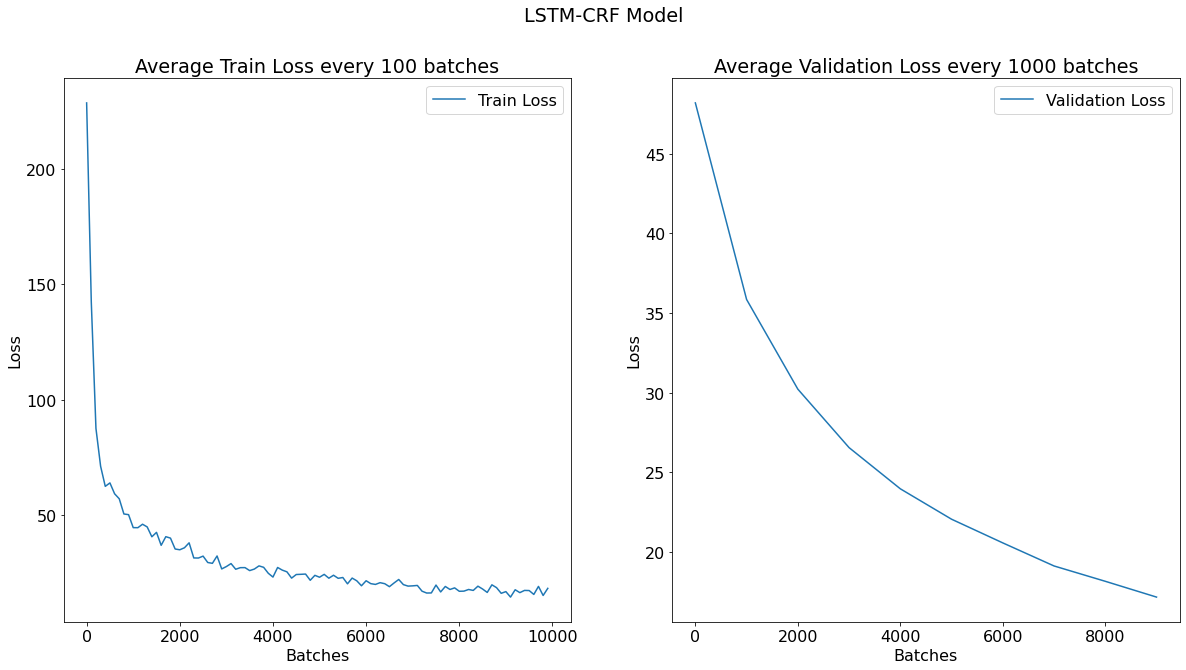

In [156]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(range(0,10000,100),loss_train,label='Train Loss')
plt.title('Average Train Loss every 100 batches')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(0,10000,1000),loss_val,label='Validation Loss')
plt.title('Average Validation Loss every 1000 batches')
plt.xlabel('Batches')
plt.ylabel('Loss')
plt.legend()
plt.suptitle('LSTM-CRF Model')
plt.show()

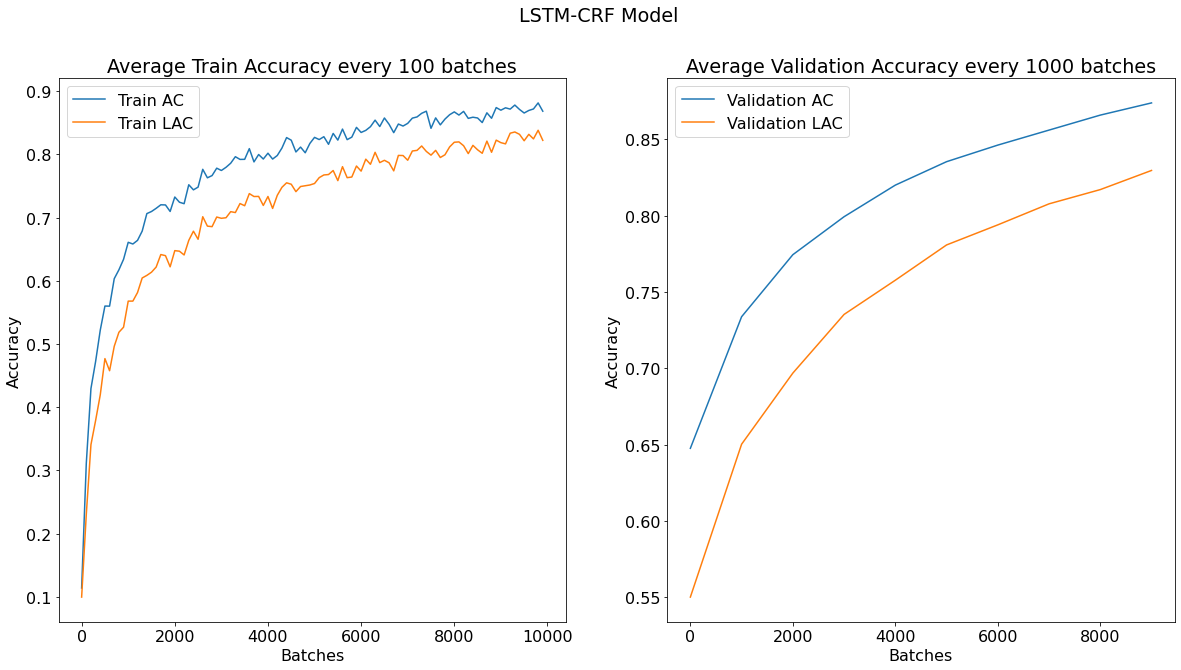

In [157]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.plot(range(0,10000,100),acc_train,label='Train AC')
plt.plot(range(0,10000,100),lacc_train,label='Train LAC')
plt.title('Average Train Accuracy every 100 batches')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(range(0,10000,1000),acc_val,label='Validation AC')
plt.plot(range(0,10000,1000),lacc_val,label='Validation LAC')
plt.title('Average Validation Accuracy every 1000 batches')
plt.xlabel('Batches')
plt.ylabel('Accuracy')
plt.legend()
plt.suptitle('LSTM-CRF Model')
plt.show()

In [158]:
evaluate(MyTagger, train_dataset)
print('=======================')
evaluate(MyTagger, validation_dataset)
print('=======================')
evaluate(MyTagger, test_dataset)


==========val============
Loss: 15.340554237365723
AC: 0.8854576255987274
LAC: 0.8418129845489996
==========val============
Loss: 17.16259765625
AC: 0.8739762724837352
LAC: 0.8297067171239356
==========val============
Loss: 16.703901290893555
AC: 0.8757850045699797
LAC: 0.831128701136532


(16.703901290893555, 0.8757850045699797, 0.831128701136532)